## Creating regional files of tracks based on the IPCC AR6 regions for South America ##
https://github.com/SantanderMetGroup/ATLAS/blob/main/notebooks/reference-regions_Python.ipynb

In [1]:
pip install regionmask

Looking in indexes: https://metoffice.jfrog.io/metoffice/api/pypi/pypi/simple
You should consider upgrading via the '/home/h03/hgilmour/.conda/envs/myclone/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import regionmask
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas

**Testing how IPCC regions work**

In [2]:
ar6_all = regionmask.defined_regions.ar6.all

In [3]:
sam = ar6_all[[9, 10, 11, 12, 14, 50, 51, 52]]

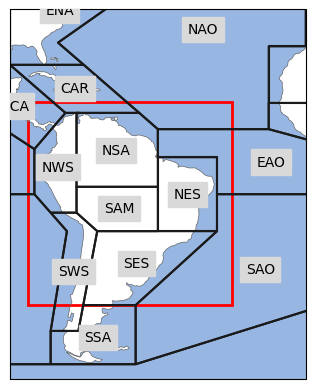

In [4]:
import matplotlib.patches as mpatches

ax = ar6_all.plot(label="abbrev", add_ocean=True)
ax.set_extent([-90, -10, -60, 40], ccrs.PlateCarree())
ax.add_patch(mpatches.Rectangle(xy=[-85, -40], width=55, height=55, linewidth=2,
                                facecolor='none', edgecolor='red',
                                transform=ccrs.PlateCarree()))


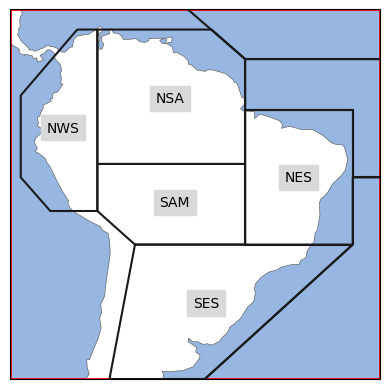

In [5]:
projection = ccrs.PlateCarree(central_longitude=180)

ax = sam.plot(label="abbrev", add_ocean=True)

ax.set_extent([-85, -30, -40, 15], ccrs.PlateCarree())

ax.add_patch(mpatches.Rectangle(xy=[-85, -40], width=55, height=55, linewidth=2,
                                facecolor='none', edgecolor='red',
                                transform=ccrs.PlateCarree()))

In [6]:
filename_2001_h = '/scratch/hgilmour/cpm_HINDCAST/total_precip/yearly_files/regridded/regridded_total_precip_2001.nc'
precip_2001_h = xr.open_dataset(filename_2001_h)
precip_2001_h = precip_2001_h.unknown

filename_2001_obs = '/scratch/hgilmour/obs/precip/precip_2001.nc'
precip_2001_obs = xr.open_dataset(filename_2001_obs)
precip_2001_obs = precip_2001_obs.precipitation_flux

filename_2001_pd = '/scratch/hgilmour/cpm_PD/total_precip/annual_files/regridded/regridded_total_precip_2001.nc'
precip_2001_pd = xr.open_dataset(filename_2001_pd)
precip_2001_pd = precip_2001_pd.unknown

FileNotFoundError: [Errno 2] No such file or directory: b'/scratch/hgilmour/cpm_HINDCAST/total_precip/yearly_files/regridded/regridded_total_precip_2001.nc'

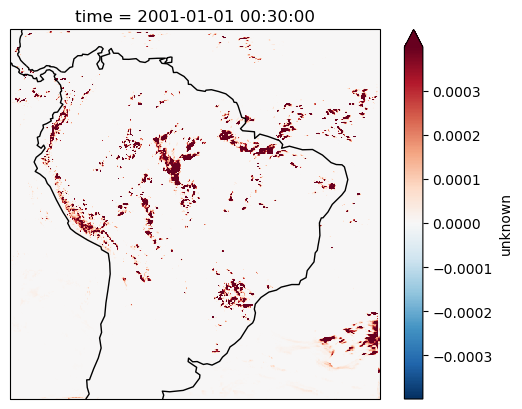

In [ ]:
proj = ccrs.PlateCarree()

f, ax = plt.subplots(subplot_kw=dict(projection=proj))

h = precip_2001_pd.isel(time=0).plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), robust=True, center=0
)

ax.coastlines()

In [ ]:
mask_2D = sam.mask(precip_2001_pd, lon_name='longitude', lat_name='latitude')


/home/h03/hgilmour/.conda/envs/myclone/lib/python3.9/site-packages/regionmask/core/mask.py:178: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


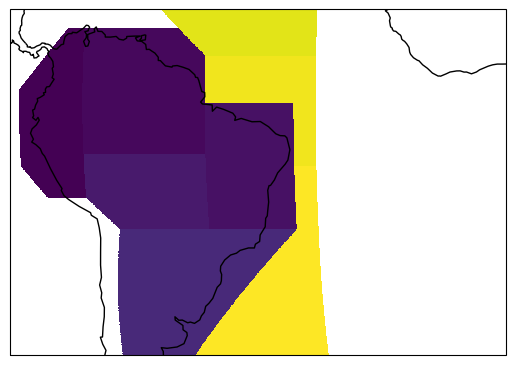

In [33]:
proj = ccrs.Robinson()
f, ax = plt.subplots(subplot_kw=dict(projection=proj))

h = mask_2D.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)

ax.coastlines()

sam.plot_regions(line_kws=dict(lw=0.5), add_label=False);

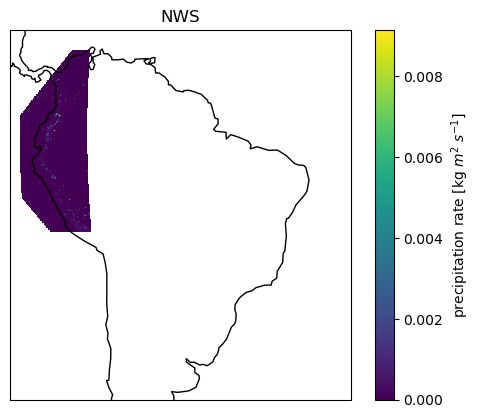

In [36]:
precip_sam = precip_2001_pd.isel(time=0).where(mask_2D == 9)

proj = ccrs.Robinson()

ax = plt.subplot(111, projection=proj)

precip_sam.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'precipitation rate [kg $m^2$ $s^{-1}$]'})

ax.set_title('NWS')

ax.coastlines()

**Creating the regional tracks files**

In [7]:
ar6_all = regionmask.defined_regions.ar6.all ## get all ipcc ar6 regions

s_america = ar6_all[[9, 10, 11, 12, 14]] ## subselect for just regions in south america (sam)

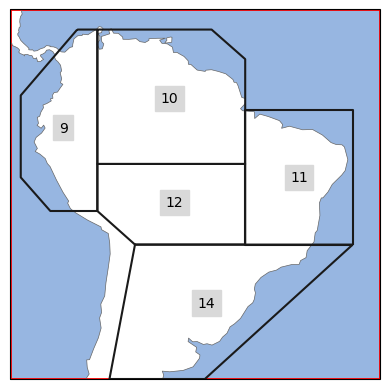

In [8]:
## plotting these for reference

import matplotlib.patches as mpatches

projection = ccrs.PlateCarree(central_longitude=180)

ax = s_america.plot(add_ocean=True)

ax.set_extent([-85, -30, -40, 15], ccrs.PlateCarree())

ax.add_patch(mpatches.Rectangle(xy=[-85, -40], width=55, height=55, linewidth=2,
                                facecolor='none', edgecolor='red',
                                transform=ccrs.PlateCarree()))

In [9]:
## convert the masked regions to a geodataframe. This creates polygons and allows you to check if a point is within a masked area

s_america_gdf = s_america.to_geodataframe()
s_america_gdf

abbrevs                   names  \
numbers                                   
9           NWS       N.W.South-America   
10          NSA         N.South-America   
11          NES       N.E.South-America   
12          SAM  South-American-Monsoon   
14          SES       S.E.South-America   

                                                  geometry  
numbers                                                     
9        POLYGON ((-75.00000 12.00000, -74.57143 12.000...  
10       POLYGON ((-72.00000 12.00000, -71.56410 12.000...  
11       POLYGON ((-34.00000 -20.00000, -34.43243 -20.0...  
12       POLYGON ((-66.40000 -20.00000, -66.71111 -19.7...  
14       POLYGON ((-34.00000 -20.00000, -34.32353 -20.2...

In [10]:
## separate out all the regions

nws = s_america_gdf[s_america_gdf.abbrevs == 'NWS']
nsa = s_america_gdf[s_america_gdf.abbrevs == 'NSA']
nes = s_america_gdf[s_america_gdf.abbrevs == 'NES']
sam = s_america_gdf[s_america_gdf.abbrevs == 'SAM']
ses = s_america_gdf[s_america_gdf.abbrevs == 'SES']

In [26]:
## Load in CCPF tracks dataframes for CPM-Hindcast and CPM-PD

file_cpm_h_tracks = '/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/merged/all_years_combined_CCPF/all_years_CCPF_cpm_hindcast.hdf'

cpm_h_tracks = pd.read_hdf(file_cpm_h_tracks, 'table')

cpm_h_tracks ## this includes 1998-2001


# Need to remane the columns to latitude and longitude (and -360 from the longitude) for velocity function and plotting to work 
cpm_h_tracks.rename(columns={'projection_x_coordinate': 'longitude', 'projection_y_coordinate': 'latitude'}, inplace=True)
#all_years_CCPF.rename(columns={'projection_x_coordinate': 'longitude', 'projection_y_coordinate': 'latitude'}, inplace=True)

cpm_h_tracks.longitude = cpm_h_tracks.longitude - 360
cpm_h_tracks

frame  idx       hdim_1      hdim_2   num  threshold_value  feature  \
15651   1380   93   771.369817  211.990152  2412              240    15652   
15660   1381   90   775.818514  218.611922  4572              240    15661   
15670   1382   96   773.524616  217.623450  5171              240    15671   
15679   1383   91   767.841475  228.466812  7251              240    15680   
15691   1384  160   765.556522  225.455483  8047              240    15692   
...      ...  ...          ...         ...   ...              ...      ...   
66806   5797  143  1331.028885  129.840527  9599              240    66807   
66814   5798  132  1322.638850  133.542454  9341              240    66815   
66825   5799  144  1316.733783  132.185515  9368              240    66826   
66836   5800  170  1311.974914  129.992302  9545              240    66837   
66848   5801  186  1306.702427  135.564077  7561              240    66849   

                      time             timestr   latitude  ...  \
15651  1998-02-27 12:30:00 1998-02-27 12:30:00  -8.799573  ...   
15660  1998-02-27 13:30:00 1998-02-27 13:30:00  -8.619401  ...   
15670  1998-02-27 14:30:00 1998-02-27 14:30:00  -8.712304  ...   
15679  1998-02-27 15:30:00 1998-02-27 15:30:00  -8.942471  ...   
15691  1998-02-27 16:30:00 1998-02-27 16:30:00  -9.035011  ...   
...                    ...                 ...        ...  ...   
66806  2007-08-30 13:30:00 2007-08-30 13:30:00  13.866618  ...   
66814  2007-08-30 14:30:00 2007-08-30 14:30:00  13.526824  ...   
66825  2007-08-30 15:30:00 2007-08-30 15:30:00  13.287669  ...   
66836  2007-08-30 16:30:00 2007-08-30 16:30:00  13.094935  ...   
66848  2007-08-30 17:30:00 2007-08-30 17:30:00  12.881397  ...   

                 datetime  max_precip_lat max_precip_lon  min_tb_lat  \
15651 1998-02-27 12:30:00           -8.05     -76.349998       -8.05   
15660 1998-02-27 13:30:00           -8.15         -75.75       -7.75   
15670 1998-02-27 14:30:00           -8.35         -75.75       -8.25   
15679 1998-02-27 15:30:00           -8.75         -75.75       -8.45   
15691 1998-02-27 16:30:00          -10.75     -74.449997       -9.55   
...                   ...             ...            ...         ...   
66806 2007-08-30 13:30:00           13.15     -81.050003       14.95   
66814 2007-08-30 14:30:00            9.25     -81.050003       14.95   
66825 2007-08-30 15:30:00            9.75     -80.949997       11.25   
66836 2007-08-30 16:30:00            9.65     -80.949997       11.25   
66848 2007-08-30 17:30:00               0              0           0   

       min_tb_lon  max_w_up_lat  max_w_up_lon  max_w_down_lat  max_w_down_lon  \
15651  -76.449997         -8.05    -76.449997           -9.45      -75.849998   
15660  -75.349998             0             0               0               0   
15670      -75.75             0             0               0               0   
15679  -75.849998         -8.65        -75.75          -10.25          -75.75   
15691  -74.949997             0             0               0               0   
...           ...           ...           ...             ...             ...   
66806  -80.650002             0             0               0               0   
66814  -80.650002             0             0               0               0   
66825  -79.349998         10.95    -80.550003           13.85      -82.550003   
66836  -79.550003             0             0               0               0   
66848           0             0             0               0               0   

       colocated_pixels  
15651                77  
15660               106  
15670                98  
15679               146  
15691               161  
...                 ...  
66806                29  
66814                24  
66825                46  
66836                50  
66848                 0  

[423258 rows x 52 columns]

In [27]:
file_cpm_pd_tracks = '/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/final_tracks/merged/all_years_combined_CCPF/all_years_CCPF.hdf'

cpm_pd_tracks = pd.read_hdf(file_cpm_pd_tracks, 'table')

cpm_pd_tracks ## this includes 1998-2001

frame  idx       hdim_1       hdim_2    num  threshold_value  feature  \
18934   1583  214   932.498434  1282.934208   2575              240    18935   
18952   1584  190   938.967715  1286.034436   3726              240    18953   
18972   1585  167   937.961718  1262.655679   3480              240    18973   
18991   1586  147   939.568226  1256.478411   3638              240    18992   
19007   1587  141   939.847058  1255.356646   3424              240    19008   
...      ...  ...          ...          ...    ...              ...      ...   
36913   3041  384  1203.835837   106.321284   9483              240    36914   
36929   3042  421  1209.145052   111.101722   8908              240    36930   
36950   3043  393  1202.307752   106.425722  11340              240    36951   
36971   3044  375  1207.919736   114.455376  10137              240    36972   
36996   3045  320  1208.280293   112.193389  10097              240    36997   

                      time              timestr  latitude  ...  w_5_down  \
18934  1998-03-06 23:30:00  1998-03-06 23:30:00 -2.273865  ...       NaN   
18952  1998-03-07 00:30:00  1998-03-07 00:30:00 -2.011859  ...       0.0   
18972  1998-03-07 01:30:00  1998-03-07 01:30:00 -2.052602  ...       NaN   
18991  1998-03-07 02:30:00  1998-03-07 02:30:00 -1.987538  ...       NaN   
19007  1998-03-07 03:30:00  1998-03-07 03:30:00 -1.976245  ...       0.0   
...                    ...                  ...       ...  ...       ...   
36913  2007-05-07 17:30:00  2007-05-07 17:30:00  8.715302  ...       NaN   
36929  2007-05-07 18:30:00  2007-05-07 18:30:00  8.930325  ...       0.0   
36950  2007-05-07 19:30:00  2007-05-07 19:30:00  8.653413  ...       NaN   
36971  2007-05-07 20:30:00  2007-05-07 20:30:00  8.880699  ...       NaN   
36996  2007-05-07 21:30:00  2007-05-07 21:30:00  8.895301  ...       0.0   

       max_precip_lat max_precip_lon min_tb_lat  min_tb_lon  max_w_up_lat  \
18934           -1.85         -34.25      -2.25  -35.049999             0   
18952           -1.75         -34.75      -1.75  -34.349998         -1.75   
18972           -1.75         -34.75      -1.75  -36.049999             0   
18991           -1.65     -35.150002      -1.75  -34.650002             0   
19007           -1.95         -34.75      -1.65  -34.049999         -1.95   
...               ...            ...        ...         ...           ...   
36913            9.85         -80.75       9.45  -79.650002             0   
36929            9.75     -80.949997       9.35  -79.849998          9.55   
36950            9.95     -81.050003       9.75  -81.150002             0   
36971            9.95     -81.150002       7.75  -78.150002             0   
36996            8.05         -77.75       8.05      -77.75          8.05   

       max_w_up_lon  max_w_down_lat  max_w_down_lon  colocated_pixels  
18934             0               0               0                 3  
18952    -34.349998           -2.25          -33.25                19  
18972             0               0               0                51  
18991             0               0               0               104  
19007    -34.650002           -1.55      -34.150002               121  
...             ...             ...             ...               ...  
36913             0               0               0               162  
36929    -79.650002            9.65      -81.949997                99  
36950             0               0               0               116  
36971             0               0               0                97  
36996        -77.75            9.55      -79.949997                69  

[403721 rows x 52 columns]

In [31]:
## Convert all lat lon points of features in pandas dataframe to geopandas dataframe (points geometry)

cpm_h_tracks_gdf = geopandas.GeoDataFrame(cpm_h_tracks, geometry=geopandas.points_from_xy(cpm_h_tracks.longitude, cpm_h_tracks.latitude), crs="EPSG:4326")
cpm_h_tracks_gdf

cpm_pd_tracks_gdf = geopandas.GeoDataFrame(cpm_pd_tracks, geometry=geopandas.points_from_xy(cpm_pd_tracks.longitude, cpm_pd_tracks.latitude), crs="EPSG:4326")
cpm_pd_tracks_gdf

frame  idx       hdim_1       hdim_2    num  threshold_value  feature  \
18934   1583  214   932.498434  1282.934208   2575              240    18935   
18952   1584  190   938.967715  1286.034436   3726              240    18953   
18972   1585  167   937.961718  1262.655679   3480              240    18973   
18991   1586  147   939.568226  1256.478411   3638              240    18992   
19007   1587  141   939.847058  1255.356646   3424              240    19008   
...      ...  ...          ...          ...    ...              ...      ...   
36913   3041  384  1203.835837   106.321284   9483              240    36914   
36929   3042  421  1209.145052   111.101722   8908              240    36930   
36950   3043  393  1202.307752   106.425722  11340              240    36951   
36971   3044  375  1207.919736   114.455376  10137              240    36972   
36996   3045  320  1208.280293   112.193389  10097              240    36997   

                      time              timestr  latitude  ...  \
18934  1998-03-06 23:30:00  1998-03-06 23:30:00 -2.273865  ...   
18952  1998-03-07 00:30:00  1998-03-07 00:30:00 -2.011859  ...   
18972  1998-03-07 01:30:00  1998-03-07 01:30:00 -2.052602  ...   
18991  1998-03-07 02:30:00  1998-03-07 02:30:00 -1.987538  ...   
19007  1998-03-07 03:30:00  1998-03-07 03:30:00 -1.976245  ...   
...                    ...                  ...       ...  ...   
36913  2007-05-07 17:30:00  2007-05-07 17:30:00  8.715302  ...   
36929  2007-05-07 18:30:00  2007-05-07 18:30:00  8.930325  ...   
36950  2007-05-07 19:30:00  2007-05-07 19:30:00  8.653413  ...   
36971  2007-05-07 20:30:00  2007-05-07 20:30:00  8.880699  ...   
36996  2007-05-07 21:30:00  2007-05-07 21:30:00  8.895301  ...   

       max_precip_lat  max_precip_lon min_tb_lat min_tb_lon  max_w_up_lat  \
18934           -1.85          -34.25      -2.25 -35.049999             0   
18952           -1.75          -34.75      -1.75 -34.349998         -1.75   
18972           -1.75          -34.75      -1.75 -36.049999             0   
18991           -1.65      -35.150002      -1.75 -34.650002             0   
19007           -1.95          -34.75      -1.65 -34.049999         -1.95   
...               ...             ...        ...        ...           ...   
36913            9.85          -80.75       9.45 -79.650002             0   
36929            9.75      -80.949997       9.35 -79.849998          9.55   
36950            9.95      -81.050003       9.75 -81.150002             0   
36971            9.95      -81.150002       7.75 -78.150002             0   
36996            8.05          -77.75       8.05     -77.75          8.05   

       max_w_up_lon  max_w_down_lat  max_w_down_lon  colocated_pixels  \
18934             0               0               0                 3   
18952    -34.349998           -2.25          -33.25                19   
18972             0               0               0                51   
18991             0               0               0               104   
19007    -34.650002           -1.55      -34.150002               121   
...             ...             ...             ...               ...   
36913             0               0               0               162   
36929    -79.650002            9.65      -81.949997                99   
36950             0               0               0               116   
36971             0               0               0                97   
36996        -77.75            9.55      -79.949997                69   

                         geometry  
18934  POINT (-33.08113 -2.27387)  
18952  POINT (-32.95555 -2.01186)  
18972  POINT (-33.90240 -2.05260)  
18991  POINT (-34.15256 -1.98754)  
19007  POINT (-34.19801 -1.97625)  
...                           ...  
36913   POINT (-80.73394 8.71530)  
36929   POINT (-80.54031 8.93032)  
36950   POINT (-80.72971 8.65341)  
36971   POINT (-80.40450 8.88070)  
36996   POINT (-80.49611 8.89530)  

[403721 rows x 53 

In [32]:
np.unique(cpm_h_tracks_gdf.cell.values)

array([    19992,     19993,     20008, ..., 200723235, 200723245,
       200723246])

In [33]:
subset = cpm_h_tracks_gdf[cpm_h_tracks_gdf.cell == 200723235]
subset

frame  idx      hdim_1      hdim_2    num  threshold_value  feature  \
102338   8747   78  825.446556  600.916643  15277              240   102339   
102347   8748   92  829.938879  594.951130  14747              240   102348   
102355   8749   91  829.302055  590.645840  13950              240   102356   
102366   8750  103  828.651586  589.808113  14720              240   102367   
102379   8751  135  826.919365  590.648755  15152              240   102380   
102393   8752  206  830.627519  591.712584  14651              240   102394   
102406   8753  203  833.153969  596.969103  16238              240   102407   
102420   8754  213  834.715638  602.627354  16652              240   102421   

                       time             timestr  latitude  ...  \
102338  2007-12-31 11:30:00 2007-12-31 11:30:00 -6.609466  ...   
102347  2007-12-31 12:30:00 2007-12-31 12:30:00 -6.427524  ...   
102355  2007-12-31 13:30:00 2007-12-31 13:30:00 -6.453316  ...   
102366  2007-12-31 14:30:00 2007-12-31 14:30:00 -6.479660  ...   
102379  2007-12-31 15:30:00 2007-12-31 15:30:00 -6.549817  ...   
102393  2007-12-31 16:30:00 2007-12-31 16:30:00 -6.399636  ...   
102406  2007-12-31 17:30:00 2007-12-31 17:30:00 -6.297315  ...   
102420  2007-12-31 18:30:00 2007-12-31 18:30:00 -6.234066  ...   

        max_precip_lat  max_precip_lon min_tb_lat  min_tb_lon  max_w_up_lat  \
102338           -7.35      -61.049999      -7.25  -61.049999             0   
102347           -7.15      -60.950001      -7.25  -60.950001         -7.15   
102355           -7.75      -60.950001      -7.75  -60.549999             0   
102366          -10.85      -59.849998     -10.85      -59.75             0   
102379           -6.05          -61.75      -8.35      -58.75         -8.55   
102393           -6.75      -60.049999      -8.55      -60.75             0   
102406           -8.95      -58.849998      -3.95  -60.650002             0   
102420           -5.15      -59.849998      -5.25  -59.849998         -5.15   

        max_w_up_lon  max_w_down_lat  max_w_down_lon  colocated_pixels  \
102338             0               0               0               321   
102347    -60.950001           -7.65      -58.450001               351   
102355             0               0               0               389   
102366             0               0               0                 0   
102379        -58.75           -6.15          -62.25               390   
102393             0               0               0               398   
102406             0               0               0               423   
102420    -59.849998           -8.45          -58.75               422   

                          geometry  
102338  POINT (-60.70284 -6.60947)  
102347  POINT (-60.94442 -6.42752)  
102355  POINT (-61.11880 -6.45332)  
102366  POINT (-61.15273 -6.47966)  
102379  POINT (-61.11869 -6.54982)  
102393  POINT (-61.07558 -6.39964)  
102406  POINT (-60.86270 -6.29731)  
102420  POINT (-60.63353 -6.23407)  

[8 rows x 53 columns]

In [34]:
# cpm_pd_tracks_ses = pd.DataFrame()

# subset_min = subset[subset.tb_min == subset.tb_min.min()]
# # subset_min.within(nws.at[9, "geometry"])
# if subset_min.within(nsa.at[10, "geometry"]).bool() == True:
#     print('yes')
#     cpm_pd_tracks_ses = cpm_pd_tracks_ses.append(subset)
# # subset_min.within(nes.at[11, "geometry"])
# # subset_min.within(sam.at[12, "geometry"])
# # subset_min.within(ses.at[14, "geometry"])

In [35]:
# cpm_pd_tracks_ses

In [36]:
cpm_h_tracks_nws = pd.DataFrame()
cpm_h_tracks_nsa = pd.DataFrame()
cpm_h_tracks_nes = pd.DataFrame()
cpm_h_tracks_sam = pd.DataFrame()
cpm_h_tracks_ses = pd.DataFrame()

for cell in np.unique(cpm_h_tracks_gdf.cell.values):
    subset = cpm_h_tracks_gdf[cpm_h_tracks_gdf.cell == cell]
    subset = subset[subset.tb_min > 0]
    subset_min = subset[subset.tb_min == subset.tb_min.min()]
    if subset_min.within(nws.at[9, "geometry"]).bool() == True:
        cpm_h_tracks_nws = cpm_h_tracks_nws.append(subset)
    if subset_min.within(nsa.at[10, "geometry"]).bool() == True:
        cpm_h_tracks_nsa = cpm_h_tracks_nsa.append(subset)
    if subset_min.within(nes.at[11, "geometry"]).bool() == True:
        cpm_h_tracks_nes = cpm_h_tracks_nes.append(subset)
    if subset_min.within(sam.at[12, "geometry"]).bool() == True:
        cpm_h_tracks_sam = cpm_h_tracks_sam.append(subset)
    if subset_min.within(ses.at[14, "geometry"]).bool() == True:
        cpm_h_tracks_ses = cpm_h_tracks_ses.append(subset)


    

/var/tmp/ipykernel_129916/1434711628.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cpm_h_tracks_ses = cpm_h_tracks_ses.append(subset)
/var/tmp/ipykernel_129916/1434711628.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cpm_h_tracks_sam = cpm_h_tracks_sam.append(subset)
/var/tmp/ipykernel_129916/1434711628.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cpm_h_tracks_nsa = cpm_h_tracks_nsa.append(subset)
/var/tmp/ipykernel_129916/1434711628.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cpm_h_tracks_ses = cpm_h_tracks_ses.append(subset)
/var/tmp/ipykernel_129916/1434711628.py:18: FutureWarning: The frame.append meth

In [37]:
cpm_h_tracks_nws_df = pd.DataFrame(cpm_h_tracks_nws)
cpm_h_tracks_nsa_df = pd.DataFrame(cpm_h_tracks_nsa)
cpm_h_tracks_nes_df = pd.DataFrame(cpm_h_tracks_nes)
cpm_h_tracks_sam_df = pd.DataFrame(cpm_h_tracks_sam)
cpm_h_tracks_ses_df = pd.DataFrame(cpm_h_tracks_ses)


In [38]:
cpm_h_tracks_ses_df

frame  idx      hdim_1      hdim_2    num  threshold_value  feature  \
1           0    4  309.204435  522.659583  18455              240        2   
17          1    4  306.420188  530.488027  20168              240       18   
27          2    6  305.145401  537.970912  20883              240       28   
36          3    4  306.054666  546.025834  20922              240       37   
46          4    5  307.441517  555.486422  20260              240       47   
...       ...  ...         ...         ...    ...              ...      ...   
101106   8652    8  282.658706  763.551625  29908              240   101107   
101117   8653   16  271.840054  784.043220  28688              240   101118   
101127   8654   11  262.916894  802.152017  27708              240   101128   
101137   8655   15  258.971390  811.753817  26876              240   101138   
101148   8656   20  255.711550  827.031289  28421              240   101149   

                       time             timestr   latitude  ...  \
1       1999-01-01 00:30:00 1999-01-01 00:30:00 -27.517271  ...   
17      1999-01-01 01:30:00 1999-01-01 01:30:00 -27.630033  ...   
27      1999-01-01 02:30:00 1999-01-01 02:30:00 -27.681661  ...   
36      1999-01-01 03:30:00 1999-01-01 03:30:00 -27.644837  ...   
46      1999-01-01 04:30:00 1999-01-01 04:30:00 -27.588669  ...   
...                     ...                 ...        ...  ...   
101106  2007-12-27 12:30:00 2007-12-27 12:30:00 -28.592372  ...   
101117  2007-12-27 13:30:00 2007-12-27 13:30:00 -29.030529  ...   
101127  2007-12-27 14:30:00 2007-12-27 14:30:00 -29.391916  ...   
101137  2007-12-27 15:30:00 2007-12-27 15:30:00 -29.551709  ...   
101148  2007-12-27 16:30:00 2007-12-27 16:30:00 -29.683733  ...   

        max_precip_lat  max_precip_lon min_tb_lat  min_tb_lon  max_w_up_lat  \
1           -27.450001      -66.050003 -26.450001  -63.049999    -27.450001   
17              -26.85      -65.449997     -26.75  -62.549999             0   
27              -26.85      -65.349998 -26.950001  -65.349998             0   
36          -26.950001      -65.349998     -27.25  -65.150002    -27.049999   
46              -26.75      -64.849998 -26.950001  -61.650002             0   
...                ...             ...        ...         ...           ...   
101106          -25.25      -56.450001 -23.950001  -58.049999        -24.15   
101117      -24.549999      -57.849998 -24.450001  -57.950001             0   
101127      -24.450001      -58.549999 -24.950001  -57.650002             0   
101137      -24.450001      -58.549999     -24.65  -58.049999    -24.549999   
101148      -28.049999      -48.950001     -24.85      -57.75             0   

        max_w_up_lon  max_w_down_lat  max_w_down_lon  colocated_pixels  \
1         -66.050003          -25.65      -62.950001               255   
17                 0               0               0               217   
27                 0               0               0               199   
36        -65.449997          -26.25          -60.75               271   
46                 0               0               0               277   
...              ...             ...             ...               ...   
101106    -58.549999          -23.85      -58.549999                 0   
101117             0               0               0                 0   
101127             0               0               0                 0   
101137    -58.450001          -28.65          -50.25                 0   
101148             0               0               0                 0   

                           geometry  
1       POINT (-63.87225 -27.51727)  
17      POINT (-63.55519 -27.63003)  
27      POINT (-63.25212 -27.68166)  
36      POINT (-62.92589 -27.64484)  
46      POINT (-62.54274 -27.58867)  
...                             ...  
101106  POINT (-54.11612 -28.59237)  
101117  POINT (-53.28618 -29.03053)  
101127  POINT (-52.55280 -29.39192)  
101137  POINT (-52.16391 -29.55171) 

In [39]:
cpm_h_tracks_nws_df = cpm_h_tracks_nws_df.drop(columns=['geometry'])
cpm_h_tracks_nsa_df = cpm_h_tracks_nsa_df.drop(columns=['geometry'])
cpm_h_tracks_nes_df = cpm_h_tracks_nes_df.drop(columns=['geometry'])
cpm_h_tracks_sam_df = cpm_h_tracks_sam_df.drop(columns=['geometry'])
cpm_h_tracks_ses_df = cpm_h_tracks_ses_df.drop(columns=['geometry'])

In [40]:
### regional comparison analysis ###
cpm_h_tracks_nws_df.to_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/nws_tracks_h.hdf', 'table')
cpm_h_tracks_nsa_df.to_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/nsa_tracks_h.hdf', 'table')
cpm_h_tracks_nes_df.to_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/nes_tracks_h.hdf', 'table')
cpm_h_tracks_sam_df.to_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/sam_tracks_h.hdf', 'table')
cpm_h_tracks_ses_df.to_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/ses_tracks_h.hdf', 'table')

/var/tmp/ipykernel_129916/3996031819.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['time', 'max_precip_lat', 'max_precip_lon', 'min_tb_lat', 'min_tb_lon',
       'max_w_up_lat', 'max_w_up_lon', 'max_w_down_lat', 'max_w_down_lon'],
      dtype='object')]

  cpm_h_tracks_nws_df.to_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/nws_tracks_h.hdf', 'table')
/var/tmp/ipykernel_129916/3996031819.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['time', 'max_precip_lat', 'max_precip_lon', 'min_tb_lat', 'min_tb_lon',
       'max_w_up_lat', 'max_w_up_lon', 'max_w_down_lat', 'max_w_down_lon'],
      dtype='object')]

  cpm_h_tracks_nsa_df.to_hdf